# Supervised LSTM Performance Analysis

## Notebook Overview 
This notebook is dedicated to the evaluation of a supervised LSTM model, trained according to the _evaluate_autoencoders_ notebook available in the project.

### Imports
This section imports essential libraries used throughout the notebook and adds the 'src' directory to the system path to allow importing modules from the source folder. 

In [1]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.metrics import mean_squared_error
# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from dl_models import LSTMBasic as lstmb
from dl_models import LSTMKfold as lstmk

from utils import plots as plt

## Introductory test
Following the baseline Autoencoder test on Building 1 (see first notebook), we now switch to a supervised LSTM approach to better leverage the sequential nature of the data for next-step forecasting. Unlike the autoencoder, this model is explicitly trained to predict the future time step given a fixed-length input sequence.

In [2]:
# Time series data for a specific building (Building_1.csv/Building_2.csv/Building_3.csv).
electricity_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Concatenate multiple datasets along the columns to create a single dataset.
df = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)

# Displaying the last 5 samples of the dataframe to show its structure.
df.tail()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
715,6,20,6,0,24.468618,0.024173,54.277103,0.442291,0.398354,5.189857,...,32.905895,89.465866,73.861000,40.875510,0.0,110.15520,0.0,0.0,271.32200,0.0
716,6,21,6,0,24.444859,0.000415,54.351337,0.990416,0.199180,4.550693,...,32.669003,87.158066,66.389130,64.036320,0.0,216.20418,0.0,0.0,151.80556,0.0
717,6,22,6,0,24.444464,0.000019,54.532566,1.563732,0.000000,4.043389,...,29.979940,100.000000,58.228535,51.990180,0.0,259.28485,0.0,0.0,374.21823,0.0
718,6,23,6,0,24.444452,0.000009,54.647182,0.421510,0.000000,3.268111,...,28.337627,90.768420,35.361465,60.445404,0.0,272.40073,0.0,0.0,582.50290,0.0
719,6,24,6,0,21.812447,0.145780,63.234272,0.374985,0.000000,6.492827,...,25.415920,82.899440,47.129494,56.078560,0.0,129.96535,0.0,0.0,842.14680,0.0


In [3]:
# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']

In [13]:
_, real_1, pred_1, model = lstmb.lstm_forecast(dataframe=df, features=features, timesteps=3, epochs=200, batch_size=128, hidden_units=64)

Epoch 1/200
5/5 - 1s - loss: 0.1156 - 1s/epoch - 220ms/step
Epoch 2/200
5/5 - 0s - loss: 0.0454 - 39ms/epoch - 8ms/step
Epoch 3/200
5/5 - 0s - loss: 0.0341 - 36ms/epoch - 7ms/step
Epoch 4/200
5/5 - 0s - loss: 0.0289 - 38ms/epoch - 8ms/step
Epoch 5/200
5/5 - 0s - loss: 0.0247 - 37ms/epoch - 7ms/step
Epoch 6/200
5/5 - 0s - loss: 0.0224 - 45ms/epoch - 9ms/step
Epoch 7/200
5/5 - 0s - loss: 0.0207 - 37ms/epoch - 7ms/step
Epoch 8/200
5/5 - 0s - loss: 0.0195 - 38ms/epoch - 8ms/step
Epoch 9/200
5/5 - 0s - loss: 0.0181 - 29ms/epoch - 6ms/step
Epoch 10/200
5/5 - 0s - loss: 0.0172 - 34ms/epoch - 7ms/step
Epoch 11/200
5/5 - 0s - loss: 0.0162 - 33ms/epoch - 7ms/step
Epoch 12/200
5/5 - 0s - loss: 0.0153 - 27ms/epoch - 5ms/step
Epoch 13/200
5/5 - 0s - loss: 0.0147 - 30ms/epoch - 6ms/step
Epoch 14/200
5/5 - 0s - loss: 0.0140 - 27ms/epoch - 5ms/step
Epoch 15/200
5/5 - 0s - loss: 0.0136 - 23ms/epoch - 5ms/step
Epoch 16/200
5/5 - 0s - loss: 0.0131 - 25ms/epoch - 5ms/step
Epoch 17/200
5/5 - 0s - loss: 0.0

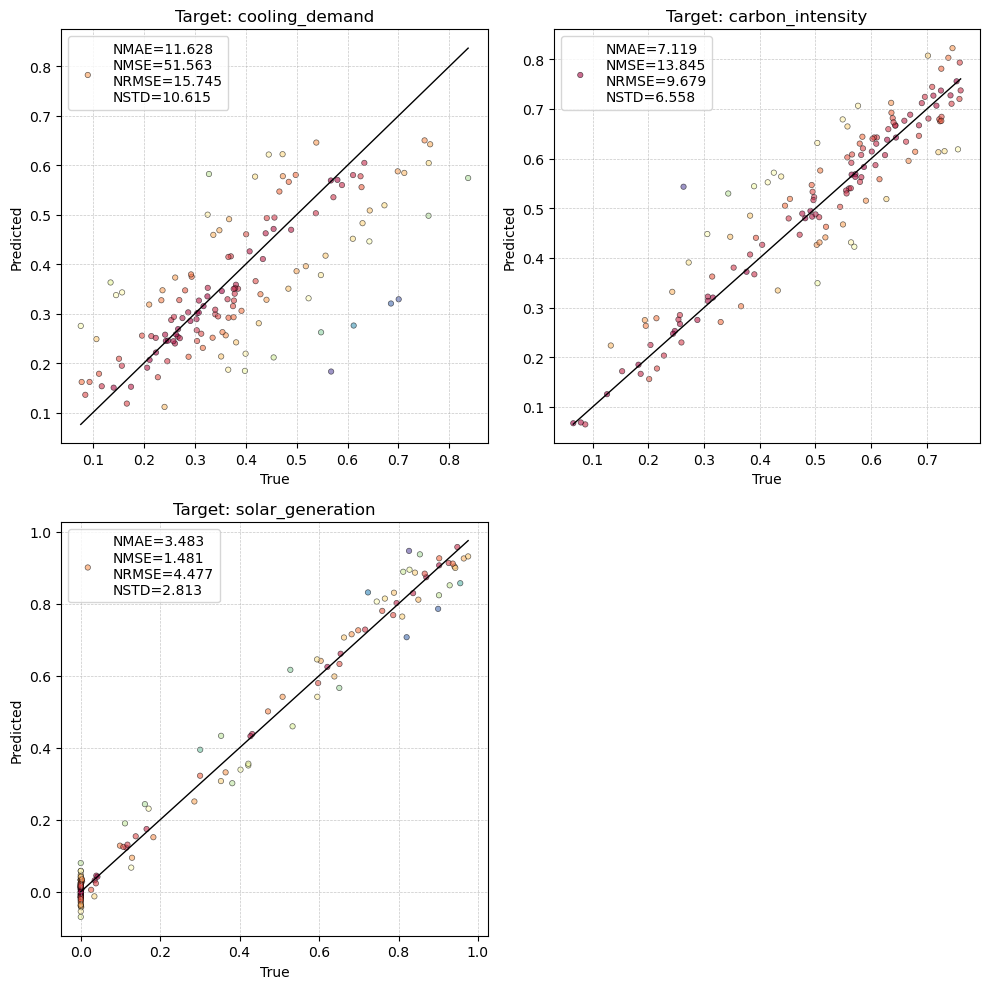

In [14]:
plt.plot_targets(real_1, pred_1, targets, features, percent=True)

## Cross-Building Test
The targets and the model remain unchanged. For this phase, we will use 100% of the data from Building 1 for training, while the remaining two buildings, being triplets with the first, will be used to evaluate the model's performance.

In [15]:
## Time series data for all buildings
building_1_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")
building_2_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
building_3_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")

# Concatenate train and test data
train_df = pd.concat([building_1_data, carbon_data, pricing_data, weather_data], axis=1)

# Concatenate the data from Building 2 and Building 3 vertically, creating a unified dataset for evaluation
building_2_3_data = pd.concat([building_2_data, building_3_data], axis=0, ignore_index=True)

# Combine carbon intensity, pricing, and weather data horizontally to align with building data
external_data = pd.concat([carbon_data, pricing_data, weather_data], axis=1)

# Repeat the external data (carbon, pricing, weather) to match the number of rows in Building 2 and 3 data
external_data_repeated = pd.concat([external_data] * 2, axis=0, ignore_index=True)

# Combine the building data and the repeated external data horizontally, preparing the final test dataset
test_df = pd.concat([building_2_3_data, external_data_repeated], axis=1)

In [17]:
_, real_2, pred_2, model = lstmb.lstm_forecast(train_df=train_df, test_df=test_df, features=features, timesteps=3, epochs=200, batch_size=64, hidden_units=32)
model.save(os.path.join("..", "reports", "models", "LSTM_generalization.h5"))

Epoch 1/200
12/12 - 1s - loss: 0.0925 - 1s/epoch - 94ms/step
Epoch 2/200
12/12 - 0s - loss: 0.0381 - 65ms/epoch - 5ms/step
Epoch 3/200
12/12 - 0s - loss: 0.0281 - 68ms/epoch - 6ms/step
Epoch 4/200
12/12 - 0s - loss: 0.0233 - 59ms/epoch - 5ms/step
Epoch 5/200
12/12 - 0s - loss: 0.0208 - 60ms/epoch - 5ms/step
Epoch 6/200
12/12 - 0s - loss: 0.0187 - 57ms/epoch - 5ms/step
Epoch 7/200
12/12 - 0s - loss: 0.0173 - 59ms/epoch - 5ms/step
Epoch 8/200
12/12 - 0s - loss: 0.0161 - 54ms/epoch - 5ms/step
Epoch 9/200
12/12 - 0s - loss: 0.0152 - 55ms/epoch - 5ms/step
Epoch 10/200
12/12 - 0s - loss: 0.0146 - 50ms/epoch - 4ms/step
Epoch 11/200
12/12 - 0s - loss: 0.0138 - 51ms/epoch - 4ms/step
Epoch 12/200
12/12 - 0s - loss: 0.0134 - 47ms/epoch - 4ms/step
Epoch 13/200
12/12 - 0s - loss: 0.0130 - 46ms/epoch - 4ms/step
Epoch 14/200
12/12 - 0s - loss: 0.0126 - 47ms/epoch - 4ms/step
Epoch 15/200
12/12 - 0s - loss: 0.0122 - 46ms/epoch - 4ms/step
Epoch 16/200
12/12 - 0s - loss: 0.0118 - 46ms/epoch - 4ms/step
Ep

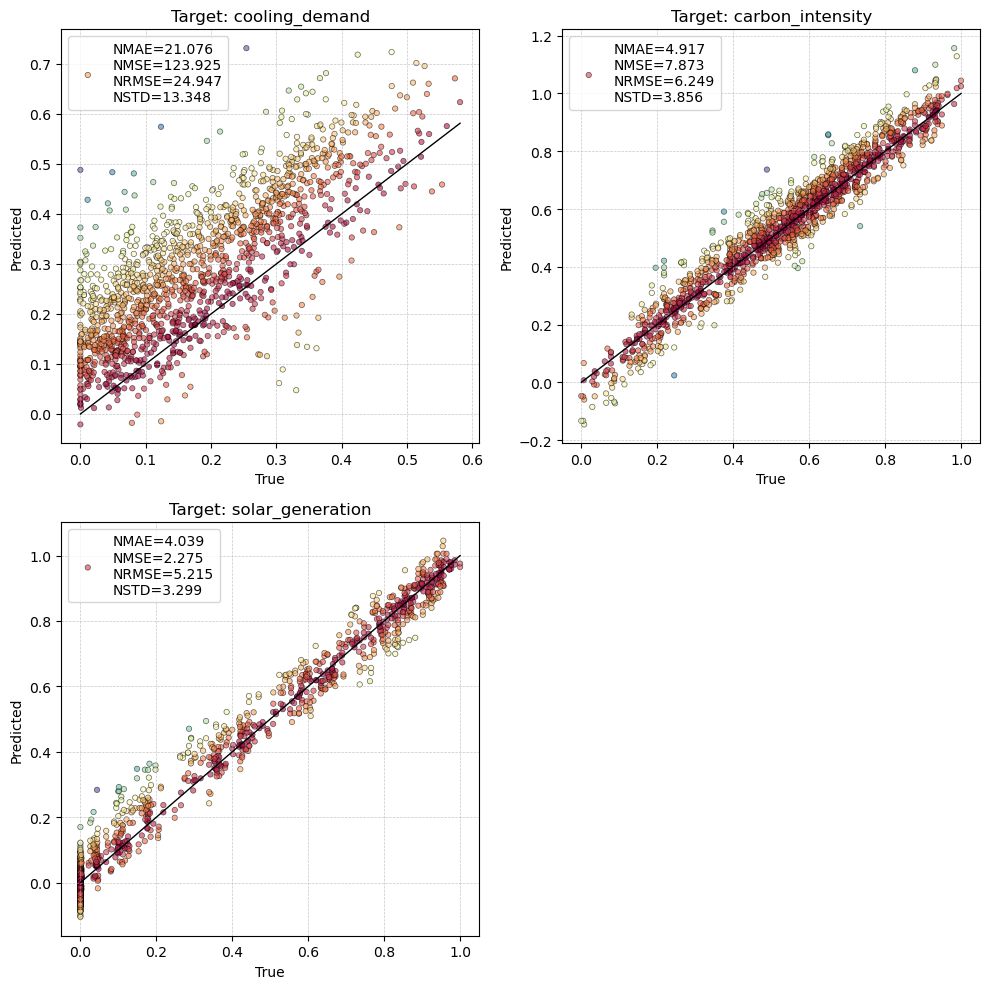

In [19]:
plt.plot_targets(real_2, pred_2, targets, features, percent=True)

## With K-fold Cross Validation
To ensure a more robust and unbiased evaluation of the supervised LSTM performance, a K-Fold Cross-Validation approach is adopted.

### Tuning

In [20]:
electricity_d = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
df2 = pd.concat([electricity_d, carbon_data, pricing_data, weather_data], axis=1)

In [22]:
real_3, pred_3, model = lstmk.lstm_forecast(dataframe = df2, features = features, epochs = 50, batch_size = 16, hidden_units = 16, timesteps = 3, kfold = 3)
model.save(os.path.join("..", "reports", "models", "LSTM_kfoldtuning.h5"))


Fold 1/3
Epoch 1/50
30/30 - 1s - loss: 0.0705 - 1s/epoch - 40ms/step
Epoch 2/50
30/30 - 0s - loss: 0.0321 - 139ms/epoch - 5ms/step
Epoch 3/50
30/30 - 0s - loss: 0.0273 - 123ms/epoch - 4ms/step
Epoch 4/50
30/30 - 0s - loss: 0.0244 - 118ms/epoch - 4ms/step
Epoch 5/50
30/30 - 0s - loss: 0.0228 - 126ms/epoch - 4ms/step
Epoch 6/50
30/30 - 0s - loss: 0.0223 - 123ms/epoch - 4ms/step
Epoch 7/50
30/30 - 0s - loss: 0.0214 - 110ms/epoch - 4ms/step
Epoch 8/50
30/30 - 0s - loss: 0.0205 - 113ms/epoch - 4ms/step
Epoch 9/50
30/30 - 0s - loss: 0.0202 - 111ms/epoch - 4ms/step
Epoch 10/50
30/30 - 0s - loss: 0.0194 - 109ms/epoch - 4ms/step
Epoch 11/50
30/30 - 0s - loss: 0.0187 - 108ms/epoch - 4ms/step
Epoch 12/50
30/30 - 0s - loss: 0.0186 - 105ms/epoch - 4ms/step
Epoch 13/50
30/30 - 0s - loss: 0.0183 - 106ms/epoch - 4ms/step
Epoch 14/50
30/30 - 0s - loss: 0.0176 - 105ms/epoch - 3ms/step
Epoch 15/50
30/30 - 0s - loss: 0.0180 - 105ms/epoch - 3ms/step
Epoch 16/50
30/30 - 0s - loss: 0.0176 - 108ms/epoch - 4m

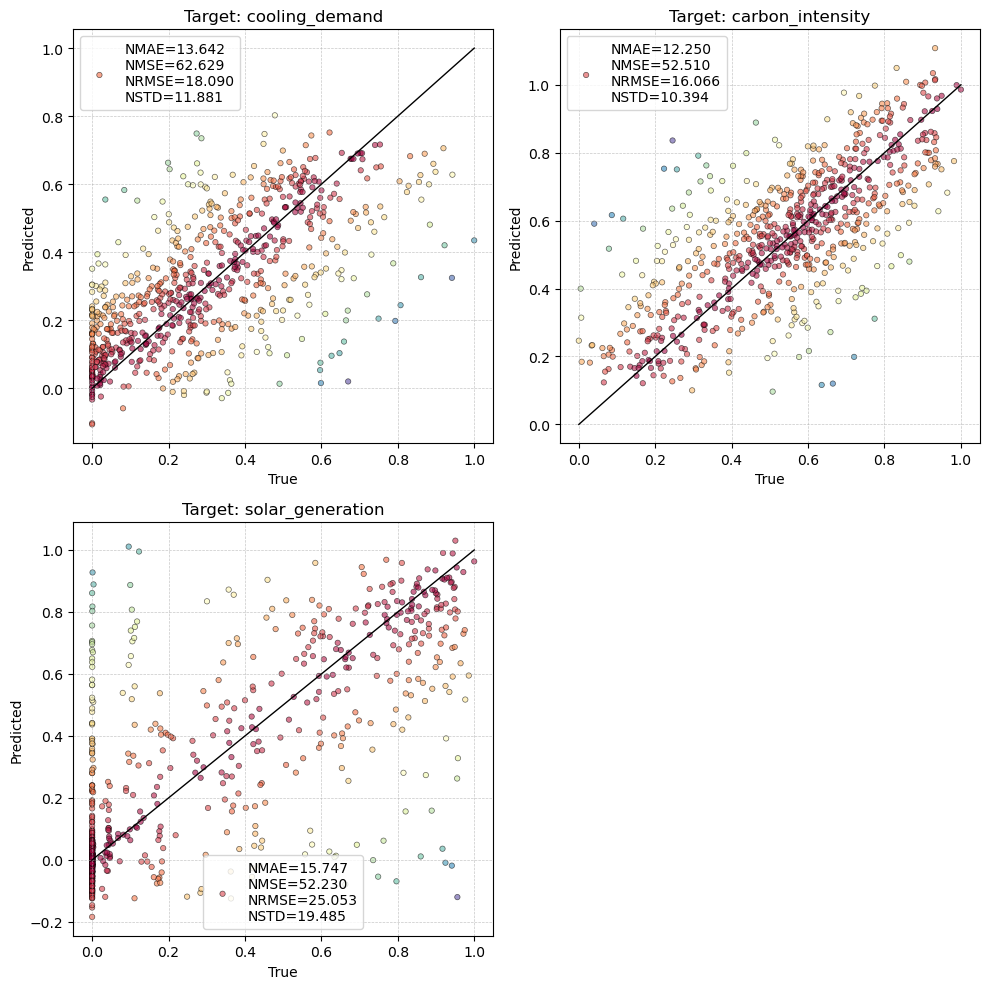

In [23]:
plt.plot_targets(real_3, pred_3, targets, features, percent=True)

### Final Training

In [24]:
electricity_d = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")
df3 = pd.concat([electricity_d, carbon_data, pricing_data, weather_data], axis=1)

In [25]:
real_4, pred_4, model = lstmk.lstm_forecast(dataframe=df3, features=features, epochs = 150, hidden_units = 16, batch_size = 16, timesteps = 3)
model.save(os.path.join("..", "reports", "models", "LSTM_kfoldtrain.h5"))

Epoch 1/150
36/36 - 1s - loss: 0.0739 - 1s/epoch - 34ms/step
Epoch 2/150
36/36 - 0s - loss: 0.0274 - 159ms/epoch - 4ms/step
Epoch 3/150
36/36 - 0s - loss: 0.0229 - 150ms/epoch - 4ms/step
Epoch 4/150
36/36 - 0s - loss: 0.0201 - 139ms/epoch - 4ms/step
Epoch 5/150
36/36 - 0s - loss: 0.0185 - 144ms/epoch - 4ms/step
Epoch 6/150
36/36 - 0s - loss: 0.0175 - 136ms/epoch - 4ms/step
Epoch 7/150
36/36 - 0s - loss: 0.0167 - 135ms/epoch - 4ms/step
Epoch 8/150
36/36 - 0s - loss: 0.0159 - 136ms/epoch - 4ms/step
Epoch 9/150
36/36 - 0s - loss: 0.0152 - 133ms/epoch - 4ms/step
Epoch 10/150
36/36 - 0s - loss: 0.0148 - 131ms/epoch - 4ms/step
Epoch 11/150
36/36 - 0s - loss: 0.0142 - 127ms/epoch - 4ms/step
Epoch 12/150
36/36 - 0s - loss: 0.0138 - 125ms/epoch - 3ms/step
Epoch 13/150
36/36 - 0s - loss: 0.0132 - 128ms/epoch - 4ms/step
Epoch 14/150
36/36 - 0s - loss: 0.0134 - 127ms/epoch - 4ms/step
Epoch 15/150
36/36 - 0s - loss: 0.0126 - 126ms/epoch - 3ms/step
Epoch 16/150
36/36 - 0s - loss: 0.0124 - 123ms/epoc

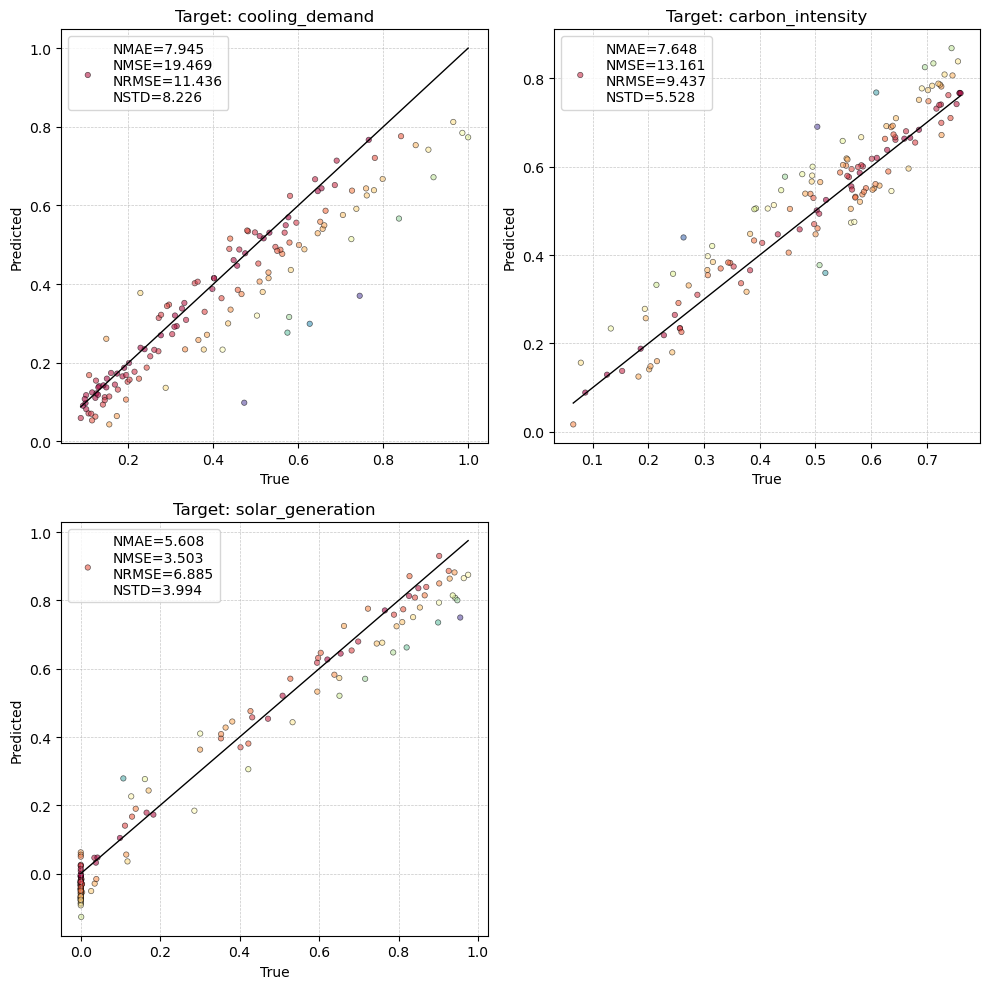

In [26]:
plt.plot_targets(real_4, pred_4, targets, features, percent=True)